# Train Mask -> SLO on Colab TPU (v6e-1)

This notebook is configured for Google Drive data at:
`/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/SLO_VESSELS`

Recommended runtime:
1. Runtime -> Change runtime type
2. Hardware accelerator: `TPU`
3. TPU type: `v6e-1` (if available)
        


In [1]:
from google.colab import drive

drive.mount('/content/drive')
        


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -q install --upgrade numpy Pillow tqdm
        


In [3]:
from pathlib import Path

# Paths
DATA_DIR = Path('/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/SLO_VESSELS')
OUTPUT_DIR = Path('/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1')

# Training config
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 512
EPOCHS = 200
BATCH_SIZE = 2
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
VAL_FRACTION = 0.2
HFLIP_PROB = 0.5
VFLIP_PROB = 0.0
ROTATE_DEG = 10.0
BASE_CHANNELS = 32
NUM_WORKERS = 0
SEED = 42
GRAD_CLIP = 1.0
USE_AMP = False  # TPU path ignores AMP
REQUIRE_TPU = True

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / 'previews').mkdir(parents=True, exist_ok=True)

print('DATA_DIR exists:', DATA_DIR.exists())
print('OUTPUT_DIR:', OUTPUT_DIR)
        


DATA_DIR exists: True
OUTPUT_DIR: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1


In [4]:
import contextlib
import json
import random
import re
from dataclasses import dataclass
from typing import Dict, List, Sequence, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

VALID_IMAGE_SUFFIXES = {'.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'}
PAIR_REGEX = re.compile(r'^(slo|vessels)_(\d+)$', re.IGNORECASE)

# Runtime detection: TPU (torch_xla) preferred for v6e-1
use_tpu = False
xm = None
pl = None
xr = None
torch_xla = None

try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.runtime as xr

    runtime_type = xr.device_type().upper()
    if runtime_type == 'TPU':
        use_tpu = True
except Exception as e:
    print('torch_xla not available or TPU init failed:', e)

if REQUIRE_TPU and not use_tpu:
    raise RuntimeError(
        'TPU runtime not active. In Colab choose TPU runtime (v6e-1 if available), reconnect, and rerun.'
    )

if use_tpu:
    device = xm.xla_device()

    def sync_step() -> None:
        if hasattr(torch_xla, 'sync'):
            torch_xla.sync()
        else:
            xm.mark_step()
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def sync_step() -> None:
        return None

print('Torch:', torch.__version__)
print('Using TPU:', use_tpu)
print('Device:', device)


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if not use_tpu and torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


@dataclass(frozen=True)
class PairRecord:
    index: int
    mask_path: Path
    slo_path: Path


def discover_pairs(data_dir: Path) -> List[PairRecord]:
    grouped: Dict[int, Dict[str, Path]] = {}
    for path in sorted(data_dir.glob('*')):
        if not path.is_file() or path.suffix.lower() not in VALID_IMAGE_SUFFIXES:
            continue
        match = PAIR_REGEX.match(path.stem)
        if not match:
            continue
        kind, idx_str = match.groups()
        idx = int(idx_str)
        grouped.setdefault(idx, {})[kind.lower()] = path

    records: List[PairRecord] = []
    missing: List[int] = []
    for idx in sorted(grouped):
        slot = grouped[idx]
        if 'slo' not in slot or 'vessels' not in slot:
            missing.append(idx)
            continue
        records.append(PairRecord(index=idx, mask_path=slot['vessels'], slo_path=slot['slo']))

    if missing:
        raise ValueError(f'Incomplete pairs for indices: {missing}')
    if not records:
        raise ValueError(f'No slo_<n> + vessels_<n> pairs found in {data_dir}')
    return records


def split_pairs(records: Sequence[PairRecord], val_fraction: float, seed: int) -> Tuple[List[PairRecord], List[PairRecord]]:
    if not (0.0 < val_fraction < 1.0):
        raise ValueError('val_fraction must be in (0, 1)')
    shuffled = list(records)
    rng = random.Random(seed)
    rng.shuffle(shuffled)
    val_count = max(1, int(round(len(shuffled) * val_fraction)))
    train = shuffled[val_count:]
    val = shuffled[:val_count]
    if not train:
        raise ValueError('Train split is empty; lower val_fraction or add data')
    return train, val


class SLOPairDataset(Dataset):
    def __init__(
        self,
        records: Sequence[PairRecord],
        image_width: int,
        image_height: int,
        augment: bool,
        hflip_prob: float,
        vflip_prob: float,
        rotate_deg: float,
    ) -> None:
        self.records = list(records)
        self.image_width = image_width
        self.image_height = image_height
        self.augment = augment
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.rotate_deg = rotate_deg

    def __len__(self) -> int:
        return len(self.records)

    def _sync_augment(self, mask_img: Image.Image, slo_img: Image.Image):
        if random.random() < self.hflip_prob:
            mask_img = ImageOps.mirror(mask_img)
            slo_img = ImageOps.mirror(slo_img)
        if random.random() < self.vflip_prob:
            mask_img = ImageOps.flip(mask_img)
            slo_img = ImageOps.flip(slo_img)
        if self.rotate_deg > 0:
            angle = random.uniform(-self.rotate_deg, self.rotate_deg)
            mask_img = mask_img.rotate(angle, resample=Image.Resampling.NEAREST, fillcolor=0)
            slo_img = slo_img.rotate(angle, resample=Image.Resampling.BILINEAR, fillcolor=0)
        return mask_img, slo_img

    def __getitem__(self, idx: int):
        rec = self.records[idx]
        with Image.open(rec.mask_path) as mask_img, Image.open(rec.slo_path) as slo_img:
            mask_img = mask_img.convert('L')
            slo_img = slo_img.convert('L')

            if mask_img.size != slo_img.size:
                raise ValueError(f'Size mismatch index {rec.index}: {mask_img.size} vs {slo_img.size}')

            if self.augment:
                mask_img, slo_img = self._sync_augment(mask_img, slo_img)

            mask_img = mask_img.resize((self.image_width, self.image_height), resample=Image.Resampling.NEAREST)
            slo_img = slo_img.resize((self.image_width, self.image_height), resample=Image.Resampling.BILINEAR)

            mask_arr = np.asarray(mask_img, dtype=np.float32) / 255.0
            slo_arr = np.asarray(slo_img, dtype=np.float32) / 255.0

        return {
            'mask': torch.from_numpy(mask_arr).unsqueeze(0),
            'slo': torch.from_numpy(slo_arr).unsqueeze(0),
            'index': rec.index,
        }


class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class Down(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.pool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pool_conv(x)


class Up(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int) -> None:
        super().__init__()
        self.conv = DoubleConv(in_ch + skip_ch, out_ch)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


class UNetGenerator(nn.Module):
    def __init__(self, in_ch: int = 1, out_ch: int = 1, base_ch: int = 32) -> None:
        super().__init__()
        self.in_conv = DoubleConv(in_ch, base_ch)
        self.down1 = Down(base_ch, base_ch * 2)
        self.down2 = Down(base_ch * 2, base_ch * 4)
        self.down3 = Down(base_ch * 4, base_ch * 8)
        self.bottleneck = Down(base_ch * 8, base_ch * 8)

        self.up1 = Up(base_ch * 8, base_ch * 8, base_ch * 4)
        self.up2 = Up(base_ch * 4, base_ch * 4, base_ch * 2)
        self.up3 = Up(base_ch * 2, base_ch * 2, base_ch)
        self.up4 = Up(base_ch, base_ch, base_ch)
        self.out_conv = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        xb = self.bottleneck(x4)
        x = self.up1(xb, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return torch.sigmoid(self.out_conv(x))


def save_preview(mask: torch.Tensor, pred: torch.Tensor, target: torch.Tensor, out_path: Path) -> None:
    mask_u8 = (mask.squeeze().detach().cpu().numpy().clip(0, 1) * 255.0).astype(np.uint8)
    pred_u8 = (pred.squeeze().detach().cpu().numpy().clip(0, 1) * 255.0).astype(np.uint8)
    tgt_u8 = (target.squeeze().detach().cpu().numpy().clip(0, 1) * 255.0).astype(np.uint8)
    tiled = np.concatenate([mask_u8, pred_u8, tgt_u8], axis=1)
    Image.fromarray(tiled, mode='L').save(out_path)
        


/tmp/ipython-input-1246637707.py:44: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


Torch: 2.9.0+cpu
Using TPU: True
Device: xla:0


In [5]:
set_seed(SEED)
records = discover_pairs(DATA_DIR)
train_records, val_records = split_pairs(records, VAL_FRACTION, SEED)

print(f'Total pairs: {len(records)} | Train: {len(train_records)} | Val: {len(val_records)}')
print('Train indices:', [r.index for r in train_records])
print('Val indices:', [r.index for r in val_records])

train_ds = SLOPairDataset(
    records=train_records,
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    augment=True,
    hflip_prob=HFLIP_PROB,
    vflip_prob=VFLIP_PROB,
    rotate_deg=ROTATE_DEG,
)
val_ds = SLOPairDataset(
    records=val_records,
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    augment=False,
    hflip_prob=0.0,
    vflip_prob=0.0,
    rotate_deg=0.0,
)

train_host_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(not use_tpu and torch.cuda.is_available()),
)
val_host_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(not use_tpu and torch.cuda.is_available()),
)

train_loader = pl.MpDeviceLoader(train_host_loader, device) if use_tpu else train_host_loader
val_loader = pl.MpDeviceLoader(val_host_loader, device) if use_tpu else val_host_loader

model = UNetGenerator(base_ch=BASE_CHANNELS).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = nn.L1Loss()

amp_enabled = bool((not use_tpu) and (device.type == 'cuda') and USE_AMP)
scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
amp_context = torch.cuda.amp.autocast if amp_enabled else contextlib.nullcontext

history = []
best_val = float('inf')
        


Total pairs: 22 | Train: 18 | Val: 4
Train indices: [10, 13, 17, 20, 7, 14, 19, 15, 11, 2, 12, 5, 18, 8, 9, 1, 4, 21]
Val indices: [22, 6, 3, 16]


/tmp/ipython-input-614680002.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)


In [6]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []

    for batch in tqdm(train_loader, desc=f'Epoch {epoch:03d} train', leave=False):
        if use_tpu:
            masks = batch['mask']
            targets = batch['slo']
        else:
            masks = batch['mask'].to(device, non_blocking=True)
            targets = batch['slo'].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with amp_context():
            preds = model(masks)
            loss = criterion(preds, targets)

        if use_tpu:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            xm.optimizer_step(optimizer, barrier=True)
            sync_step()
        else:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()

        train_losses.append(float(loss.detach().cpu().item()))

    model.eval()
    val_losses = []
    preview_saved = False

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch:03d} val', leave=False):
            if use_tpu:
                masks = batch['mask']
                targets = batch['slo']
            else:
                masks = batch['mask'].to(device, non_blocking=True)
                targets = batch['slo'].to(device, non_blocking=True)

            preds = model(masks)
            val_loss = criterion(preds, targets)
            val_losses.append(float(val_loss.detach().cpu().item()))

            if not preview_saved:
                preview_path = OUTPUT_DIR / 'previews' / f'epoch_{epoch:03d}.png'
                save_preview(masks[0], preds[0], targets[0], preview_path)
                preview_saved = True

        sync_step()

    train_l1 = float(np.mean(train_losses)) if train_losses else float('nan')
    val_l1 = float(np.mean(val_losses)) if val_losses else train_l1
    scheduler.step(val_l1)
    lr = optimizer.param_groups[0]['lr']

    row = {'epoch': epoch, 'train_l1': train_l1, 'val_l1': val_l1, 'lr': lr}
    history.append(row)

    checkpoint = {
        'epoch': epoch,
        'model_state': {k: v.detach().cpu() for k, v in model.state_dict().items()},
        'optimizer_state': optimizer.state_dict(),
        'args': {
            'image_width': IMAGE_WIDTH,
            'image_height': IMAGE_HEIGHT,
            'base_channels': BASE_CHANNELS,
            'hflip_prob': HFLIP_PROB,
            'vflip_prob': VFLIP_PROB,
            'rotate_deg': ROTATE_DEG,
            'batch_size': BATCH_SIZE,
            'epochs': EPOCHS,
            'learning_rate': LEARNING_RATE,
            'weight_decay': WEIGHT_DECAY,
            'val_fraction': VAL_FRACTION,
            'seed': SEED,
            'data_dir': str(DATA_DIR),
            'output_dir': str(OUTPUT_DIR),
            'use_tpu': use_tpu,
        },
        'train_records': [r.index for r in train_records],
        'val_records': [r.index for r in val_records],
        'history': history,
        'best_val': best_val,
    }

    torch.save(checkpoint, OUTPUT_DIR / 'latest.pt')

    if val_l1 < best_val:
        best_val = val_l1
        checkpoint['best_val'] = best_val
        torch.save(checkpoint, OUTPUT_DIR / 'best.pt')

    print(f"Epoch {epoch:03d}/{EPOCHS} | train_l1={train_l1:.6f} | val_l1={val_l1:.6f} | lr={lr:.2e}")

(OUTPUT_DIR / 'history.json').write_text(json.dumps(history, indent=2), encoding='utf-8')
(OUTPUT_DIR / 'train_config.json').write_text(
    json.dumps(
        {
            'data_dir': str(DATA_DIR),
            'image_width': IMAGE_WIDTH,
            'image_height': IMAGE_HEIGHT,
            'train_count': len(train_records),
            'val_count': len(val_records),
            'hflip_prob': HFLIP_PROB,
            'vflip_prob': VFLIP_PROB,
            'rotate_deg': ROTATE_DEG,
            'best_val_l1': best_val,
            'use_tpu': use_tpu,
        },
        indent=2,
    ),
    encoding='utf-8',
)

print('Training complete. Best val_l1:', best_val)
print('Saved under:', OUTPUT_DIR)
        


Epoch 001 train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Epoch 001/200 | train_l1=0.117869 | val_l1=0.113041 | lr=1.00e-04


Epoch 002/200 | train_l1=0.112411 | val_l1=0.112350 | lr=1.00e-04


Epoch 003/200 | train_l1=0.109374 | val_l1=0.106727 | lr=1.00e-04


Epoch 004/200 | train_l1=0.106970 | val_l1=0.124346 | lr=1.00e-04


Epoch 005/200 | train_l1=0.108973 | val_l1=0.103154 | lr=1.00e-04


Epoch 006/200 | train_l1=0.105886 | val_l1=0.098946 | lr=1.00e-04


Epoch 007/200 | train_l1=0.101653 | val_l1=0.100150 | lr=1.00e-04


Epoch 008/200 | train_l1=0.100090 | val_l1=0.099091 | lr=1.00e-04


Epoch 009/200 | train_l1=0.098018 | val_l1=0.094931 | lr=1.00e-04


Epoch 010/200 | train_l1=0.097980 | val_l1=0.101788 | lr=1.00e-04


Epoch 011/200 | train_l1=0.097436 | val_l1=0.102551 | lr=1.00e-04


Epoch 012/200 | train_l1=0.093560 | val_l1=0.097033 | lr=1.00e-04


Epoch 013/200 | train_l1=0.096757 | val_l1=0.112039 | lr=1.00e-04


Epoch 014/200 | train_l1=0.096732 | val_l1=0.098398 | lr=1.00e-04


Epoch 015/200 | train_l1=0.095938 | val_l1=0.093790 | lr=1.00e-04


Epoch 016/200 | train_l1=0.095352 | val_l1=0.114710 | lr=1.00e-04


Epoch 017/200 | train_l1=0.095393 | val_l1=0.095617 | lr=1.00e-04


Epoch 018/200 | train_l1=0.093448 | val_l1=0.099566 | lr=1.00e-04


Epoch 019/200 | train_l1=0.094708 | val_l1=0.100335 | lr=1.00e-04


Epoch 020/200 | train_l1=0.089072 | val_l1=0.112619 | lr=1.00e-04


Epoch 021/200 | train_l1=0.093422 | val_l1=0.113317 | lr=1.00e-04


Epoch 022/200 | train_l1=0.090347 | val_l1=0.096171 | lr=1.00e-04


Epoch 023/200 | train_l1=0.088596 | val_l1=0.091421 | lr=1.00e-04


Epoch 024/200 | train_l1=0.089491 | val_l1=0.094492 | lr=1.00e-04


Epoch 025/200 | train_l1=0.085383 | val_l1=0.096211 | lr=1.00e-04


Epoch 026/200 | train_l1=0.089800 | val_l1=0.092868 | lr=1.00e-04


Epoch 027/200 | train_l1=0.085873 | val_l1=0.093049 | lr=1.00e-04


Epoch 028/200 | train_l1=0.089164 | val_l1=0.089901 | lr=1.00e-04


Epoch 029/200 | train_l1=0.087171 | val_l1=0.107264 | lr=1.00e-04


Epoch 030/200 | train_l1=0.085384 | val_l1=0.104811 | lr=1.00e-04


Epoch 031/200 | train_l1=0.090037 | val_l1=0.088291 | lr=1.00e-04


Epoch 032/200 | train_l1=0.087212 | val_l1=0.088932 | lr=1.00e-04


Epoch 033/200 | train_l1=0.087964 | val_l1=0.106077 | lr=1.00e-04


Epoch 034/200 | train_l1=0.089582 | val_l1=0.093287 | lr=1.00e-04


Epoch 035/200 | train_l1=0.087206 | val_l1=0.091658 | lr=1.00e-04


Epoch 036/200 | train_l1=0.081271 | val_l1=0.084013 | lr=1.00e-04


Epoch 037/200 | train_l1=0.089177 | val_l1=0.110955 | lr=1.00e-04


Epoch 038/200 | train_l1=0.086054 | val_l1=0.100502 | lr=1.00e-04


Epoch 039/200 | train_l1=0.084308 | val_l1=0.081484 | lr=1.00e-04


Epoch 040/200 | train_l1=0.084927 | val_l1=0.099011 | lr=1.00e-04


Epoch 041/200 | train_l1=0.089268 | val_l1=0.096117 | lr=1.00e-04


Epoch 042/200 | train_l1=0.083359 | val_l1=0.100221 | lr=1.00e-04


Epoch 043/200 | train_l1=0.081667 | val_l1=0.089355 | lr=1.00e-04


Epoch 044/200 | train_l1=0.082226 | val_l1=0.085576 | lr=1.00e-04


Epoch 045/200 | train_l1=0.083150 | val_l1=0.094069 | lr=1.00e-04


Epoch 046/200 | train_l1=0.082956 | val_l1=0.088061 | lr=1.00e-04


Epoch 047/200 | train_l1=0.085344 | val_l1=0.105480 | lr=1.00e-04


Epoch 048/200 | train_l1=0.082501 | val_l1=0.099823 | lr=1.00e-04


Epoch 049/200 | train_l1=0.082230 | val_l1=0.083983 | lr=1.00e-04


Epoch 050/200 | train_l1=0.077997 | val_l1=0.089531 | lr=5.00e-05


Epoch 051/200 | train_l1=0.080563 | val_l1=0.092222 | lr=5.00e-05


Epoch 052/200 | train_l1=0.082336 | val_l1=0.081763 | lr=5.00e-05


Epoch 053/200 | train_l1=0.079237 | val_l1=0.083042 | lr=5.00e-05


Epoch 054/200 | train_l1=0.074373 | val_l1=0.092665 | lr=5.00e-05


Epoch 055/200 | train_l1=0.075285 | val_l1=0.093530 | lr=5.00e-05


Epoch 056/200 | train_l1=0.075587 | val_l1=0.099207 | lr=5.00e-05


Epoch 057/200 | train_l1=0.080290 | val_l1=0.087054 | lr=5.00e-05


Epoch 058/200 | train_l1=0.073599 | val_l1=0.085743 | lr=5.00e-05


Epoch 059/200 | train_l1=0.075213 | val_l1=0.087601 | lr=5.00e-05


Epoch 060/200 | train_l1=0.077733 | val_l1=0.090660 | lr=5.00e-05


Epoch 061/200 | train_l1=0.076199 | val_l1=0.083122 | lr=2.50e-05


Epoch 062/200 | train_l1=0.072606 | val_l1=0.084505 | lr=2.50e-05


Epoch 063/200 | train_l1=0.075673 | val_l1=0.085554 | lr=2.50e-05


Epoch 064/200 | train_l1=0.069580 | val_l1=0.088610 | lr=2.50e-05


Epoch 065/200 | train_l1=0.071359 | val_l1=0.088268 | lr=2.50e-05


Epoch 066/200 | train_l1=0.069508 | val_l1=0.081655 | lr=2.50e-05


Epoch 067/200 | train_l1=0.064004 | val_l1=0.081298 | lr=2.50e-05


Epoch 068/200 | train_l1=0.072085 | val_l1=0.085257 | lr=2.50e-05


Epoch 069/200 | train_l1=0.068839 | val_l1=0.085832 | lr=2.50e-05


Epoch 070/200 | train_l1=0.072573 | val_l1=0.083800 | lr=2.50e-05


Epoch 071/200 | train_l1=0.069387 | val_l1=0.081501 | lr=2.50e-05


Epoch 072/200 | train_l1=0.072886 | val_l1=0.083312 | lr=2.50e-05


Epoch 073/200 | train_l1=0.071090 | val_l1=0.084681 | lr=2.50e-05


Epoch 074/200 | train_l1=0.070207 | val_l1=0.083493 | lr=2.50e-05


Epoch 075/200 | train_l1=0.068760 | val_l1=0.077794 | lr=2.50e-05


Epoch 076/200 | train_l1=0.077852 | val_l1=0.078940 | lr=2.50e-05


Epoch 077/200 | train_l1=0.068313 | val_l1=0.081737 | lr=2.50e-05


Epoch 078/200 | train_l1=0.066849 | val_l1=0.082235 | lr=2.50e-05


Epoch 079/200 | train_l1=0.070338 | val_l1=0.084228 | lr=2.50e-05


Epoch 080/200 | train_l1=0.064928 | val_l1=0.078526 | lr=2.50e-05


Epoch 081/200 | train_l1=0.070628 | val_l1=0.078036 | lr=2.50e-05


Epoch 082/200 | train_l1=0.070018 | val_l1=0.082814 | lr=2.50e-05


Epoch 083/200 | train_l1=0.066465 | val_l1=0.084992 | lr=2.50e-05


Epoch 084/200 | train_l1=0.069090 | val_l1=0.079682 | lr=2.50e-05


Epoch 085/200 | train_l1=0.068262 | val_l1=0.084304 | lr=2.50e-05


Epoch 086/200 | train_l1=0.065972 | val_l1=0.087057 | lr=1.25e-05


Epoch 087/200 | train_l1=0.063833 | val_l1=0.085837 | lr=1.25e-05


Epoch 088/200 | train_l1=0.070729 | val_l1=0.086181 | lr=1.25e-05


Epoch 089/200 | train_l1=0.069495 | val_l1=0.085540 | lr=1.25e-05


Epoch 090/200 | train_l1=0.063552 | val_l1=0.084492 | lr=1.25e-05


Epoch 091/200 | train_l1=0.064103 | val_l1=0.083563 | lr=1.25e-05


Epoch 092/200 | train_l1=0.065851 | val_l1=0.083170 | lr=1.25e-05


Epoch 093/200 | train_l1=0.063717 | val_l1=0.084895 | lr=1.25e-05


Epoch 094/200 | train_l1=0.068284 | val_l1=0.080615 | lr=1.25e-05


Epoch 095/200 | train_l1=0.067361 | val_l1=0.083021 | lr=1.25e-05


Epoch 096/200 | train_l1=0.064218 | val_l1=0.080023 | lr=1.25e-05


Epoch 097/200 | train_l1=0.067919 | val_l1=0.084336 | lr=6.25e-06


Epoch 098/200 | train_l1=0.062033 | val_l1=0.084129 | lr=6.25e-06


Epoch 099/200 | train_l1=0.065783 | val_l1=0.080305 | lr=6.25e-06


Epoch 100/200 | train_l1=0.066475 | val_l1=0.082019 | lr=6.25e-06


Epoch 101/200 | train_l1=0.061480 | val_l1=0.083575 | lr=6.25e-06


Epoch 102/200 | train_l1=0.059811 | val_l1=0.083032 | lr=6.25e-06


Epoch 103/200 | train_l1=0.064070 | val_l1=0.082789 | lr=6.25e-06


Epoch 104/200 | train_l1=0.066371 | val_l1=0.082332 | lr=6.25e-06


Epoch 105/200 | train_l1=0.066488 | val_l1=0.082460 | lr=6.25e-06


Epoch 106/200 | train_l1=0.063261 | val_l1=0.082755 | lr=6.25e-06


Epoch 107/200 | train_l1=0.069315 | val_l1=0.083271 | lr=6.25e-06


Epoch 108/200 | train_l1=0.068519 | val_l1=0.080562 | lr=3.13e-06


Epoch 109/200 | train_l1=0.067232 | val_l1=0.082623 | lr=3.13e-06


Epoch 110/200 | train_l1=0.065166 | val_l1=0.084005 | lr=3.13e-06


Epoch 111/200 | train_l1=0.063514 | val_l1=0.083409 | lr=3.13e-06


Epoch 112/200 | train_l1=0.060694 | val_l1=0.081736 | lr=3.13e-06


Epoch 113/200 | train_l1=0.063241 | val_l1=0.082906 | lr=3.13e-06


Epoch 114/200 | train_l1=0.059169 | val_l1=0.082995 | lr=3.13e-06


Epoch 115/200 | train_l1=0.069377 | val_l1=0.084025 | lr=3.13e-06


Epoch 116/200 | train_l1=0.065083 | val_l1=0.083080 | lr=3.13e-06


Epoch 117/200 | train_l1=0.060551 | val_l1=0.079064 | lr=3.13e-06


Epoch 118/200 | train_l1=0.061989 | val_l1=0.079245 | lr=3.13e-06


Epoch 119/200 | train_l1=0.063507 | val_l1=0.081788 | lr=1.56e-06


Epoch 120/200 | train_l1=0.061899 | val_l1=0.080890 | lr=1.56e-06


Epoch 121/200 | train_l1=0.061906 | val_l1=0.081294 | lr=1.56e-06


Epoch 122/200 | train_l1=0.060621 | val_l1=0.083221 | lr=1.56e-06


Epoch 123/200 | train_l1=0.061421 | val_l1=0.083871 | lr=1.56e-06


Epoch 124/200 | train_l1=0.060028 | val_l1=0.082283 | lr=1.56e-06


Epoch 125/200 | train_l1=0.063947 | val_l1=0.081544 | lr=1.56e-06


Epoch 126/200 | train_l1=0.064727 | val_l1=0.080850 | lr=1.56e-06


Epoch 127/200 | train_l1=0.064225 | val_l1=0.082396 | lr=1.56e-06


Epoch 128/200 | train_l1=0.066209 | val_l1=0.082073 | lr=1.56e-06


Epoch 129/200 | train_l1=0.066694 | val_l1=0.083260 | lr=1.56e-06


Epoch 130/200 | train_l1=0.062129 | val_l1=0.081357 | lr=7.81e-07


Epoch 131/200 | train_l1=0.060259 | val_l1=0.081514 | lr=7.81e-07


Epoch 132/200 | train_l1=0.060869 | val_l1=0.082129 | lr=7.81e-07


Epoch 133/200 | train_l1=0.065520 | val_l1=0.084074 | lr=7.81e-07


Epoch 134/200 | train_l1=0.062130 | val_l1=0.081974 | lr=7.81e-07


Epoch 135/200 | train_l1=0.062663 | val_l1=0.081878 | lr=7.81e-07


Epoch 136/200 | train_l1=0.066641 | val_l1=0.082745 | lr=7.81e-07


Epoch 137/200 | train_l1=0.067673 | val_l1=0.084517 | lr=7.81e-07


Epoch 138/200 | train_l1=0.062272 | val_l1=0.082538 | lr=7.81e-07


Epoch 139/200 | train_l1=0.065348 | val_l1=0.082097 | lr=7.81e-07


Epoch 140/200 | train_l1=0.061822 | val_l1=0.081402 | lr=7.81e-07


Epoch 141/200 | train_l1=0.057200 | val_l1=0.082375 | lr=3.91e-07


Epoch 142/200 | train_l1=0.063770 | val_l1=0.082025 | lr=3.91e-07


Epoch 143/200 | train_l1=0.064706 | val_l1=0.083520 | lr=3.91e-07


Epoch 144/200 | train_l1=0.064840 | val_l1=0.083320 | lr=3.91e-07


Epoch 145/200 | train_l1=0.063010 | val_l1=0.082493 | lr=3.91e-07


Epoch 146/200 | train_l1=0.063449 | val_l1=0.081099 | lr=3.91e-07


Epoch 147/200 | train_l1=0.065784 | val_l1=0.082232 | lr=3.91e-07


Epoch 148/200 | train_l1=0.063692 | val_l1=0.082001 | lr=3.91e-07


Epoch 149/200 | train_l1=0.062593 | val_l1=0.080296 | lr=3.91e-07


Epoch 150/200 | train_l1=0.062991 | val_l1=0.082020 | lr=3.91e-07


Epoch 151/200 | train_l1=0.067736 | val_l1=0.082962 | lr=3.91e-07


Epoch 152/200 | train_l1=0.058480 | val_l1=0.082987 | lr=1.95e-07


Epoch 153/200 | train_l1=0.059054 | val_l1=0.081864 | lr=1.95e-07


Epoch 154/200 | train_l1=0.064882 | val_l1=0.081486 | lr=1.95e-07


Epoch 155/200 | train_l1=0.061671 | val_l1=0.082808 | lr=1.95e-07


Epoch 156/200 | train_l1=0.063952 | val_l1=0.080371 | lr=1.95e-07


Epoch 157/200 | train_l1=0.061854 | val_l1=0.081070 | lr=1.95e-07


Epoch 158/200 | train_l1=0.064030 | val_l1=0.082357 | lr=1.95e-07


Epoch 159/200 | train_l1=0.059982 | val_l1=0.082742 | lr=1.95e-07


Epoch 160/200 | train_l1=0.059875 | val_l1=0.082777 | lr=1.95e-07


Epoch 161/200 | train_l1=0.062104 | val_l1=0.082898 | lr=1.95e-07


Epoch 162/200 | train_l1=0.061544 | val_l1=0.083040 | lr=1.95e-07


Epoch 163/200 | train_l1=0.064775 | val_l1=0.084252 | lr=9.77e-08


Epoch 164/200 | train_l1=0.057776 | val_l1=0.083677 | lr=9.77e-08


Epoch 165/200 | train_l1=0.065009 | val_l1=0.083371 | lr=9.77e-08


Epoch 166/200 | train_l1=0.057778 | val_l1=0.082070 | lr=9.77e-08


Epoch 167/200 | train_l1=0.061300 | val_l1=0.082325 | lr=9.77e-08


Epoch 168/200 | train_l1=0.059017 | val_l1=0.080804 | lr=9.77e-08


Epoch 169/200 | train_l1=0.062543 | val_l1=0.081727 | lr=9.77e-08


Epoch 170/200 | train_l1=0.064965 | val_l1=0.084028 | lr=9.77e-08


Epoch 171/200 | train_l1=0.061152 | val_l1=0.082278 | lr=9.77e-08


Epoch 172/200 | train_l1=0.060112 | val_l1=0.082286 | lr=9.77e-08


Epoch 173/200 | train_l1=0.062323 | val_l1=0.083549 | lr=9.77e-08


Epoch 174/200 | train_l1=0.062149 | val_l1=0.082627 | lr=4.88e-08


Epoch 175/200 | train_l1=0.062050 | val_l1=0.082246 | lr=4.88e-08


Epoch 176/200 | train_l1=0.062233 | val_l1=0.082346 | lr=4.88e-08


Epoch 177/200 | train_l1=0.062889 | val_l1=0.083376 | lr=4.88e-08


Epoch 178/200 | train_l1=0.061059 | val_l1=0.082081 | lr=4.88e-08


Epoch 179/200 | train_l1=0.061685 | val_l1=0.084529 | lr=4.88e-08


Epoch 180/200 | train_l1=0.064046 | val_l1=0.083666 | lr=4.88e-08


Epoch 181/200 | train_l1=0.058209 | val_l1=0.081640 | lr=4.88e-08


Epoch 182/200 | train_l1=0.061131 | val_l1=0.082655 | lr=4.88e-08


Epoch 183/200 | train_l1=0.060892 | val_l1=0.081197 | lr=4.88e-08


Epoch 184/200 | train_l1=0.065577 | val_l1=0.084147 | lr=4.88e-08


Epoch 185/200 | train_l1=0.059835 | val_l1=0.083320 | lr=2.44e-08


Epoch 186/200 | train_l1=0.063525 | val_l1=0.082918 | lr=2.44e-08


Epoch 187/200 | train_l1=0.062443 | val_l1=0.082875 | lr=2.44e-08


Epoch 188/200 | train_l1=0.061857 | val_l1=0.082116 | lr=2.44e-08


Epoch 189/200 | train_l1=0.064998 | val_l1=0.082123 | lr=2.44e-08


Epoch 190/200 | train_l1=0.062175 | val_l1=0.083078 | lr=2.44e-08


Epoch 191/200 | train_l1=0.062069 | val_l1=0.084082 | lr=2.44e-08


Epoch 192/200 | train_l1=0.061731 | val_l1=0.082139 | lr=2.44e-08


Epoch 193/200 | train_l1=0.060688 | val_l1=0.084388 | lr=2.44e-08


Epoch 194/200 | train_l1=0.058290 | val_l1=0.082034 | lr=2.44e-08


Epoch 195/200 | train_l1=0.056707 | val_l1=0.081025 | lr=2.44e-08


Epoch 196/200 | train_l1=0.063607 | val_l1=0.082340 | lr=1.22e-08


Epoch 197/200 | train_l1=0.060599 | val_l1=0.083311 | lr=1.22e-08


Epoch 198/200 | train_l1=0.065750 | val_l1=0.081842 | lr=1.22e-08


Epoch 199/200 | train_l1=0.064922 | val_l1=0.082390 | lr=1.22e-08


Epoch 200/200 | train_l1=0.062062 | val_l1=0.082816 | lr=1.22e-08
Training complete. Best val_l1: 0.07779377326369286
Saved under: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1


Preview count: 200


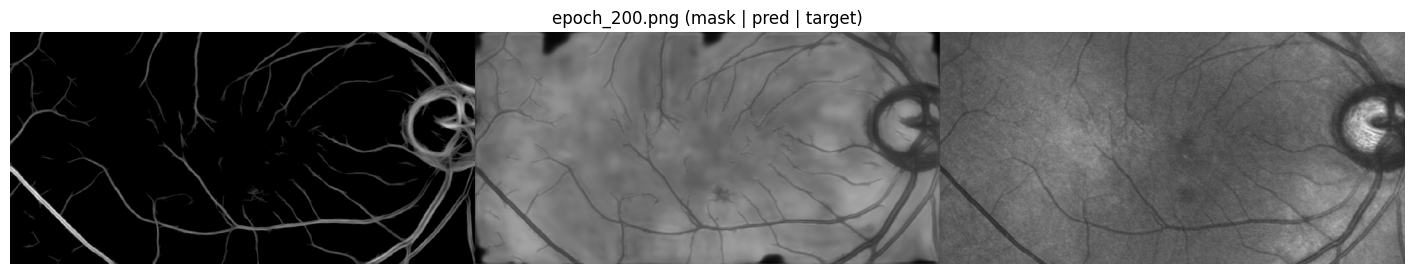

In [8]:
import matplotlib.pyplot as plt

preview_files = sorted((OUTPUT_DIR / 'previews').glob('epoch_*.png'))
print('Preview count:', len(preview_files))
if preview_files:
    sample = preview_files[-1]
    with Image.open(sample) as img:
        plt.figure(figsize=(18, 6))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(sample.name + ' (mask | pred | target)')
        plt.show()
        
